## ENU Models

In [1]:
import torch
import torch.nn as nn
from torch.nn import Linear, Parameter
from torch import sigmoid, matmul, tanh, cat, clamp, stack, Tensor, randn, ones

import numpy as np
import matplotlib.pyplot as plt
# torch.__version__ 1.3.1+cpu

In [2]:
class ENU(nn.Module):
    def __init__(self, input_channels_size, output_channels_size, batch_size=0, memory_state_size=4, 
                 inner_gate_hidden_units=7, output_gate_hidden_units=4):
        super(ENU, self).__init__()
        
        self.input_size = input_channels_size
        self.h_size = memory_state_size
        self.output_size = output_channels_size
        self.inner_gate_hidden_units = inner_gate_hidden_units
        self.output_gate_hidden_units = output_gate_hidden_units
        self.batch_size = batch_size
        
        # reset gate
        self.reset_gate = Linear(self.input_size + self.h_size + self.output_size, self.h_size)
        self.reset_gate.weights = randn(self.input_size + self.h_size + self.output_size, self.h_size, requires_grad=True)
        self.reset_gate.biass = randn(self.h_size, requires_grad=True)
        
        # update gate
        self.update_gate = Linear(self.input_size + self.h_size + self.output_size, self.h_size)
        self.reset_gate.weights = randn(self.input_size + self.h_size + self.output_size, self.h_size, requires_grad=True)
        self.reset_gate.biass = randn(self.h_size, requires_grad=True)
        
        # cell gate
        self.cell_gate = Linear(self.input_size + self.h_size + self.output_size, self.h_size)
        self.reset_gate.weights = randn(self.input_size + self.h_size + self.output_size, self.h_size, requires_grad=True)
        self.reset_gate.biass = randn(self.h_size, requires_grad=True)
        
        # output gate
        self.output_gate = Linear(self.h_size, self.output_size)
        self.reset_gate.weights = randn(self.h_size, self.output_size, requires_grad=True)
        self.reset_gate.biass = randn(self.output_size, requires_grad=True)
        
        self.predict_gate = Linear(self.output_size, 1)
        self.predict_gate.weights = randn(self.output_size, 1, requires_grad=True)
        self.predict_gate.biass = randn(1, requires_grad=True)
        
        # pre memory sate and output
        if self.batch_size == 0:
            self.h = randn(1, self.h_size)
            self.o = randn(1, self.output_size)
        else:
            self.h = randn(self.batch_size, 1, self.h_size)
            self.o = randn(self.batch_size, 1, self.output_size)
    
    def Reset_Gate(self, data):
        return self.reset_gate(data)

    def Update_Gate(self, data):
        return self.update_gate(data)

    def Cell_Gate(self, data):
        return self.cell_gate(data)

    def Output_Gate(self, data):
        return self.output_gate(data)
    
    def forward(self, x): # input each SIze(1, 3)
        self.input = cat((self.h, self.o, x), -1) # Size (1, 10)

        # Reset Gate
        self.r = sigmoid(self.Reset_Gate(self.input)) # Size (1, 4)
        # Update Gate
        self.z = sigmoid(self.Update_Gate(self.input)) # Size (1, 4)
        
        # Cell Gate
        self.cell_gate_input = cat((self.r * self.h, self.o, x), -1) # Size(1, 10)
        self.h_bar = tanh(self.Cell_Gate(self.cell_gate_input)) # Size (1, 4)
        
        # Memory State
        self.h = (1 - self.z) * self.h + self.z * self.h_bar # new memory state 
        
        # Output Gate
        self.o = clamp(self.Output_Gate(self.h), 0, 1) # Size (1, 3)

        return self.o
    
    def predict(self, output):
        return self.predict_gate(output)

## View Data Set
### ref
- https://tykimos.tistory.com/23

In [3]:
signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

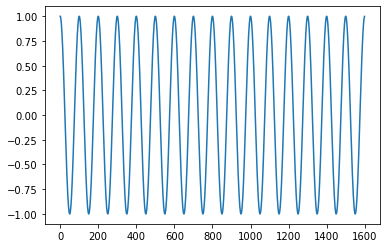

In [4]:
plot_x = np.arange(1600)
plot_y = signal_data
plt.plot(plot_x, plot_y)
plt.show()

## Create Data Set

In [5]:
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return Tensor(dataX), Tensor(dataY)

In [6]:
from sklearn.preprocessing import MinMaxScaler

look_back = 30

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

# 데이터 분리
train_size = 800
test_size = 500
train = signal_data[0:train_size + look_back]
test = signal_data[1000:1000 + test_size + look_back]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

In [7]:
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

x_train = x_train.view(train_size,1, look_back)
x_test = x_test.view(test_size, 1, look_back)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

## Set Network

In [8]:
input_channels = 3
output_channels = 3
batch_size = 100

enu = ENU(input_channels, output_channels, batch_size=batch_size)
loss = nn.MSELoss()
optimizer = torch.optim.SGD(enu.parameters(), lr=1e-1)

### Create DataLoader

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

## Train Models

In [10]:
epochs = 20
cost_per_epoch = list()

for epoch in range(1, epochs + 1):
    epoch_cost = 0
    
    for samples in train_dataloader:
        x_train, y_train = samples
        optimizer.zero_grad()
        
        for i in range(int(x_train.size()[-1] / input_channels)):
            x = x_train[:, :, i*input_channels:(i+1)*input_channels].view(batch_size, 1, input_channels)
            output = enu.forward(x)
        
        prediction = enu.predict(output)
        
        cost = loss(prediction.view(-1), y_train)
        cost.backward(retain_graph=True)

        optimizer.step()
        epoch_cost += cost.item()
        
    print('Epoch {:4d}/{} Cost: {:.6f}'.format(epoch, epochs, epoch_cost))
    cost_per_epoch.append(epoch_cost)

Epoch    1/20 Cost: 1.609374
Epoch    2/20 Cost: 0.956907
Epoch    3/20 Cost: 0.945686
Epoch    4/20 Cost: 0.934651
Epoch    5/20 Cost: 0.921423
Epoch    6/20 Cost: 0.905454
Epoch    7/20 Cost: 0.886053
Epoch    8/20 Cost: 0.862340
Epoch    9/20 Cost: 0.833209
Epoch   10/20 Cost: 0.797293
Epoch   11/20 Cost: 0.752989
Epoch   12/20 Cost: 0.698864
Epoch   13/20 Cost: 0.635578
Epoch   14/20 Cost: 0.561315
Epoch   15/20 Cost: 0.434986
Epoch   16/20 Cost: 0.310626
Epoch   17/20 Cost: 0.225812
Epoch   18/20 Cost: 0.168393
Epoch   19/20 Cost: 0.134229
Epoch   20/20 Cost: 0.114535


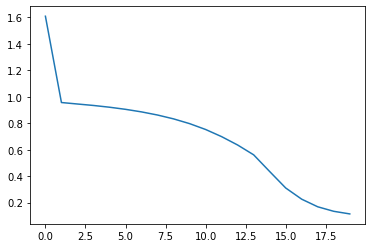

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(cost_per_epoch)

## Test Models

In [12]:
total_cost = 0
predictions = Tensor([])
for batch_idx, samples in enumerate(test_dataloader):
    x_train, y_train = samples

    for i in range(int(x_train.size()[-1] / input_channels)):
        x = x_train[:, :, i*input_channels:(i+1)*input_channels].view(batch_size, 1, input_channels)
        output = enu.forward(x)
    prediction = enu.predict(output)
    
    predictions = cat((predictions, prediction.view(-1)), 0)

    cost = loss(prediction, y_train)
    total_cost += cost.item()

print('test_loss: ', total_cost)

test_loss:  1.0956531316041946


c:\users\user\anaconda3\envs\smartshoes\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## Visual Test predictions

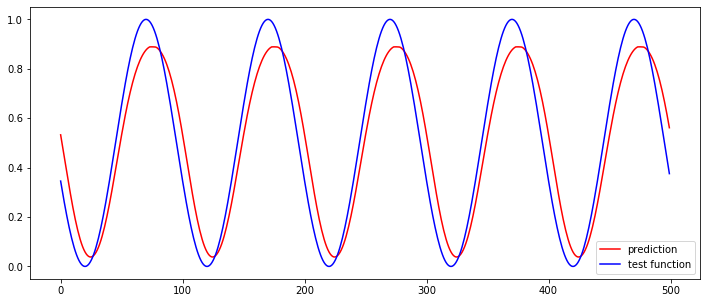

In [13]:
test_size = y_test.size()[0]

plt.figure(figsize=(12,5))
plt.plot(np.arange(test_size), predictions.detach().numpy(), 'r', label="prediction")
plt.plot(np.arange(test_size), y_test, 'b', label="test function")
plt.legend()
plt.show()

###  Visual other models

![Time-series_Numerical_Input_Numerical_Prediction_Model_Recipes.png](![Time-series_Numerical_Input_Numerical_Prediction_Model_Recipes.png](https://user-images.githubusercontent.com/40608930/72505892-2a9d1e80-3884-11ea-8cbd-8a5be578fb4d.png))